In [3]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [43]:
import spacy
nlp = spacy.load("en_core_web_sm")
print("Modelo cargado correctamente")


Modelo cargado correctamente


In [4]:
# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/nacho1907/Bases/refs/heads/main/fake_or_real_news.csv')
df = df.rename(columns={"text": "texto", "label": "sentimiento"})

In [5]:
df.head()

,Unnamed: 0,title,texto,sentimiento
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
# Contar cuantas noticias reales y fakes hay en el dataset
# Està balanceado? Còmo lo arreglarìas sino?

conteo_sentimientos = df['sentimiento'].value_counts()

print(conteo_sentimientos)

sentimiento
REAL    3171
FAKE    3164
Name: count, dtype: int64


Las cantidades estan balanceadas casi a 50% - 50%

In [7]:
# Dimensiona el dataset
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?
df.shape

(6335, 4)

In [8]:
# Corta a un nùmero reducido de noticias para facilitar el procesamiento
# Las clases quedaron balanceadas?
df_real = df[df['sentimiento'] == 'REAL']
df_fake = df[df['sentimiento'] == 'FAKE']

# Tomar una muestra aleatoria de 500 noticias de cada clase
df_real_sample = df_real.sample(n=400, random_state=42)
df_fake_sample = df_fake.sample(n=400, random_state=42)

# Unir las dos muestras
df_balanceado = pd.concat([df_real_sample, df_fake_sample])

# Mezclar aleatoriamente el dataframe final
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el balance
print(df_balanceado['sentimiento'].value_counts())


sentimiento
FAKE    400
REAL    400
Name: count, dtype: int64


In [9]:
# Ajustar etiquetas de sentimiento (0 = fake, 1 = real)
df_balanceado['sentimiento'] = df_balanceado['sentimiento'].map({'FAKE': 0, 'REAL': 1})
df_balanceado.head()

,Unnamed: 0,title,texto,sentimiento
0,8173,PAY TO PLAY : Hillary’s Two Big Favors For Mor...,PAY TO PLAY : Hillary’s Two Big Favors For Mor...,0
1,7615,Economic Racial Disparity in North Carolina,Email \nWhile the recent police shooting of Ke...,0
2,4481,Senate Debate Reveals Absurd Level Of Trade De...,The pair noted that although legislators are a...,1
3,8483,"Meteor, space junk, rocket? Mysterious flash h...","Meteor, space junk, rocket? Mysterious flash h...",0
4,2759,How the battle against the Islamic State is re...,CONFRONTING THE ‘CALIPHATE’ | This is part of ...,1


In [31]:
print(df_balanceado['texto'].isna().sum())  # Contar valores nulos
print(df_balanceado['texto'].dtype)  # Tipo de datos en la columna


0
object


In [44]:
print(type(nlp))  # Debería devolver <class 'spacy.lang.en.English'>


<class 'spacy.lang.en.English'>


In [45]:
def preprocesar_texto(texto):
    """Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales."""
    if not isinstance(texto, str) or texto.strip() == "":  # Si no es string o está vacío
        return ""

    doc = nlp(texto.lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]

    return " ".join(tokens) if tokens else ""


                                               texto  \
0  PAY TO PLAY : Hillary’s Two Big Favors For Mor...   
1  Email \nWhile the recent police shooting of Ke...   
2  The pair noted that although legislators are a...   
3  Meteor, space junk, rocket? Mysterious flash h...   
4  CONFRONTING THE ‘CALIPHATE’ | This is part of ...   

                                     texto_procesado  
0  pay play hillary two big favor morocco net mil...  
1  email recent police shooting keith lamont scot...  
2  pair note although legislator allow look text ...  
3  meteor space junk rocket mysterious flash hit ...  
4  confront caliphate part occasional series alon...  
<class 'str'>
2435253
pay play hillary two big favor morocco net million pay play hillary two big favor morocco net million break news truthfeednew october richard pollock dailycaller hillary clinton two huge favor morocco tenure secretary state clinton foundation accept million donation country ruler king mohammed vi accord new in

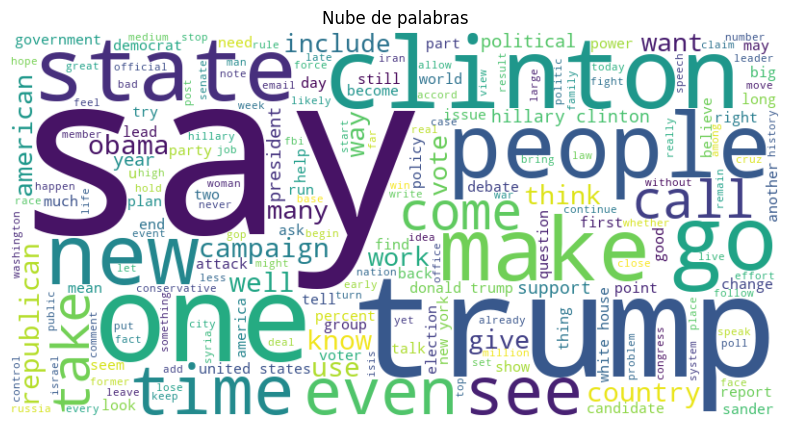

In [46]:
# Aplicar preprocesamiento
df_balanceado['texto_procesado'] = df_balanceado['texto'].apply(preprocesar_texto)


# Verificar los cambios
print(df_balanceado[['texto', 'texto_procesado']].head())

# Visualizar nube de palabras completando la secuencia de creaciòn
text_combined = " ".join(df_balanceado['texto_procesado'])
print(type(text_combined))  # Verificar tipo de dato
print(len(text_combined))   # Verificar longitud del texto
print(text_combined[:500])  # Mostrar los primeros 500 caracteres

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras")
plt.show()

Unigramas más comunes:
    N-gram  Frecuencia
0      say        3983
1    trump        3023
2  clinton        2404
3    state        1826
4    would        1738
5      one        1520
6   people        1416
7      new        1317
8     year        1300
9     make        1286


C:\Users\Usuario\AppData\Local\Temp\ipykernel_6692\2442677384.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


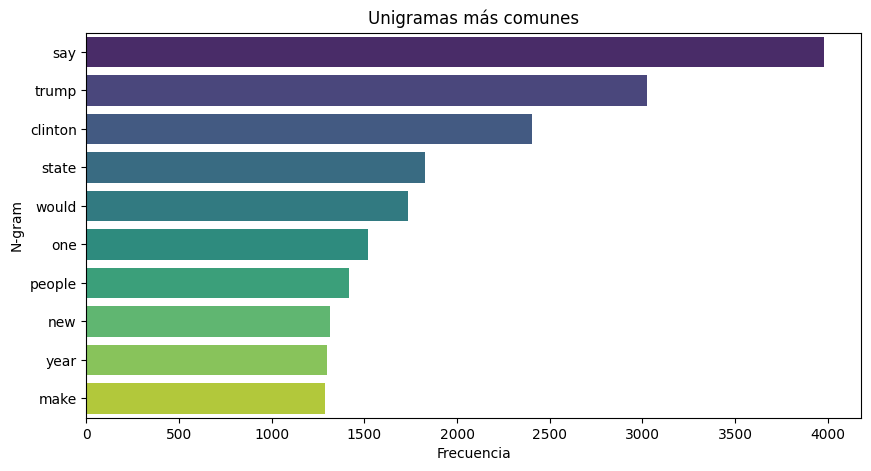


Bigramas más comunes:
             N-gram  Frecuencia
0   hillary clinton         535
1      donald trump         503
2     united states         386
3       white house         376
4          new york         338
5   president obama         181
6         trump say         168
7   secretary state         166
8  state department         147
9     supreme court         145


C:\Users\Usuario\AppData\Local\Temp\ipykernel_6692\2442677384.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


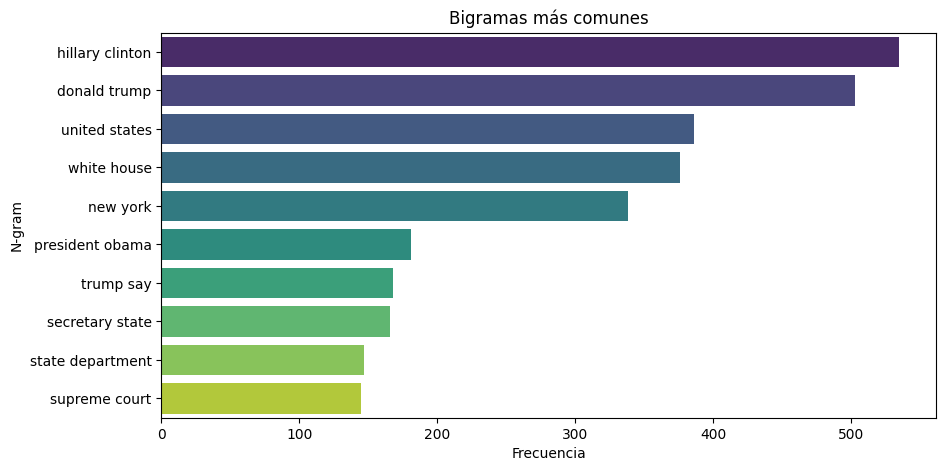

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6692\2442677384.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')



Trigramas más comunes:
                              N-gram  Frecuencia
0                     new york times         110
1                     case case case          64
2             president barack obama          55
3                       sen ted cruz          40
4            president united states          37
5  republican presidential candidate          36
6               director james comey          35
7                    sen marco rubio          35
8                 fbi director james          32
9                wall street journal          31


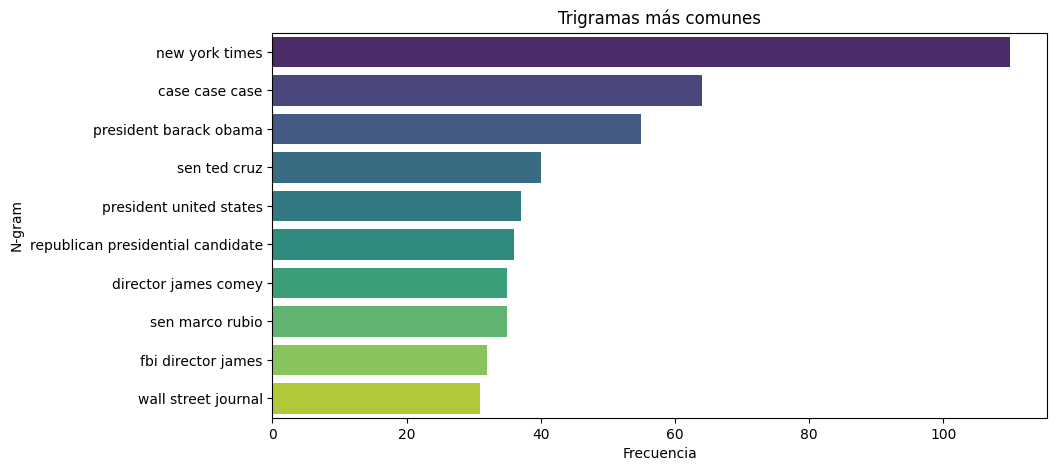


Cuatrigramas más comunes:
                               N-gram  Frecuencia
0                 case case case case          63
1            fbi director james comey          32
2                ohio gov john kasich          23
3          secretary state john kerry          22
4     majority leader mitch mcconnell          21
5             house speaker paul ryan          19
6        senate majority leader mitch          18
7  associated press contribute report          15
8   prime minister benjamin netanyahu          15
9            use private email server          15


C:\Users\Usuario\AppData\Local\Temp\ipykernel_6692\2442677384.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')


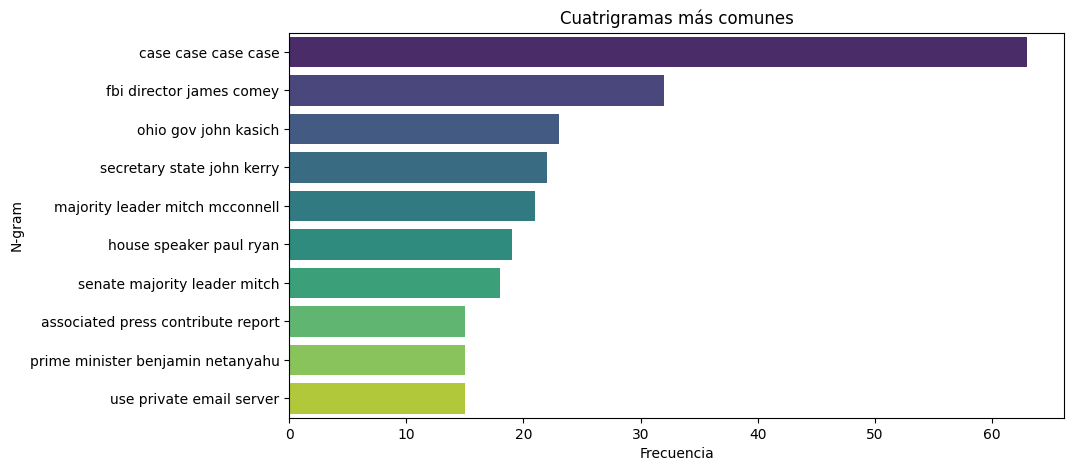

In [50]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq = list(zip(ngram_features, ngram_counts))
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]
    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])

def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, palette='viridis')
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-gram")
    plt.show()

unigrams = get_top_ngrams(df_balanceado['texto_procesado'], 1)
bigrams = get_top_ngrams(df_balanceado['texto_procesado'], 2)
trigrams = get_top_ngrams(df_balanceado['texto_procesado'], 3)
quadgrams = get_top_ngrams(df_balanceado['texto_procesado'], 4)

# Mostrar los resultados
print("Unigramas más comunes:")
print(unigrams)
plot_ngrams(unigrams, "Unigramas más comunes")

print("\nBigramas más comunes:")
print(bigrams)
plot_ngrams(bigrams, "Bigramas más comunes")

print("\nTrigramas más comunes:")
print(trigrams)
plot_ngrams(trigrams, "Trigramas más comunes")

print("\nCuatrigramas más comunes:")
print(quadgrams)
plot_ngrams(quadgrams, "Cuatrigramas más comunes")

In [53]:
# Separar datos en entrenamiento y prueba
X = df_balanceado['texto_procesado']  # Características (texto preprocesado)
y = df_balanceado['sentimiento']         # Etiqueta de clasificación (ajusta según tu dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [65]:
# Crear el pipeline con solo bigramas (n=2)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(3, 3))),  # Solo trigramas
    ('clf', MultinomialNB())
])


In [67]:
# Entrenar el modelo con el pipeline
pipeline.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

In [68]:
# Evaluar el desempeño del modelo
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.78125

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77        80
           1       0.75      0.84      0.79        80

    accuracy                           0.78       160
   macro avg       0.78      0.78      0.78       160
weighted avg       0.78      0.78      0.78       160



In [69]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [70]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [71]:
y_pred2=pac.predict(tfidf_test)

In [72]:
# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.85625
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        80
           1       0.85      0.86      0.86        80

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160



En este caso podemos ver que es mas eficiente predecir absolutismo que predecir probabilidades